In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [46]:
iphones = pd.read_csv('iphones.csv')
books = pd.read_csv('books.csv')
collectables = pd.read_csv('collectables.csv')
healthbeauty = pd.read_csv('healthbeauty.csv')
homegarden = pd.read_csv('homegarden.csv')
music = pd.read_csv('music.csv')
sporting = pd.read_csv('sporting.csv')

In [48]:
iphones.columns

Index(['item_number', ' item_title', ' payment_method', ' postal_code',
       ' shipping_method', ' sales_price', ' selling_state', ' best_offer',
       ' bin_available', ' start_time', ' end_time', ' listing_type',
       ' returns_accepted', ' condition', ' top_rated', ' seller',
       ' feedback_percentage', ' feedback_score', ' description'],
      dtype='object')

In [49]:
dataframes = [
    iphones,
    books,
    collectables,
    healthbeauty,
    homegarden,
    music,
    sporting
]

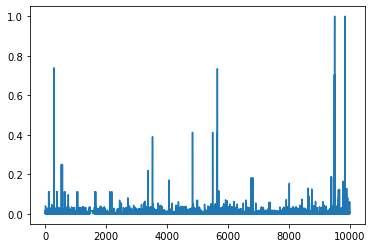

In [53]:
scaler = MinMaxScaler()


for df in dataframes:
    df[' description'] = scaler.fit_transform(df[[' description']])
    
# Test to see scaler applied
collectables[' description']
plt.plot(collectables[' description'])

In [62]:
iphones[iphones[' feedback_score'] < 1]

,item_number,item_title,payment_method,postal_code,shipping_method,sales_price,selling_state,best_offer,bin_available,start_time,end_time,listing_type,returns_accepted,condition,top_rated,seller,feedback_percentage,feedback_score,description
0,202832988171,Apple iPhone x - 64GB - Black (CDMA + GSM),PayPal,701**,Free,400.00,EndedWithoutSales,False,False,2019-11-29T02:48:11.000Z,2019-11-28T16:16:26.000Z,FixedPrice,False,3000,False,towill-5153,NaN,0.0,0.006335
21,163963971737,Apple iPhone XS Max - 256GB - Gold (AT&T) A192...,PayPal,762**,Calculated,460.00,EndedWithSales,True,False,2019-11-28T08:10:31.000Z,2019-11-28T11:07:27.000Z,FixedPrice,False,7000,False,josro1314,NaN,0.0,0.001844
25,143454438584,Iphone XS max 256gb gold,PayPal,00000,Free,359.99,EndedWithSales,False,False,2019-11-28T06:19:55.000Z,2019-11-28T07:17:06.000Z,FixedPrice,True,3000,False,lakyas_0,NaN,0.0,0.029621
26,143454430410,Iphone XS max 256gb gold,PayPal,00000,Free,359.99,EndedWithSales,False,False,2019-11-28T06:09:30.000Z,2019-11-27T18:10:11.000Z,FixedPrice,True,3000,False,lakyas_0,NaN,0.0,0.029621
27,143454414143,Iphone XS max 256gb gold,PayPal,00000,Free,389.99,EndedWithSales,False,False,2019-11-28T05:46:25.000Z,2019-11-28T05:47:53.000Z,FixedPrice,True,3000,False,lakyas_0,NaN,0.0,0.029621
38,383290197473,Apple iPhone 11 - 64GB - White (AT&T) A2111 (C...,PayPal,463**,Free,500.00,EndedWithSales,False,False,2019-11-28T03:11:51.000Z,2019-11-28T03:21:27.000Z,FixedPrice,False,1500,False,jado-1490,NaN,0.0,0.001153
43,392557796084,Apple iPhone 11 - 64GB - Purple (Verizon) A211...,PayPal,291**,Free,450.00,EndedWithSales,True,False,2019-11-28T01:40:37.000Z,2019-11-28T02:45:59.000Z,FixedPrice,True,3000,False,andbie-1,NaN,0.0,0.001339
47,143454707549,Apple iPhone XS Max - 256GB - Silver (Unlocked...,PayPal,722**,Flat,800.00,EndedWithSales,True,False,2019-11-28T01:25:55.000Z,2019-11-28T04:55:33.000Z,FixedPrice,False,3000,False,mague_89,NaN,0.0,0.001471
55,293351447688,Apple iPhone X - 64GB - Space Grey (Unlocked)f...,PayPal,951**,Free,399.00,EndedWithSales,True,False,2019-11-27T23:48:02.000Z,2019-11-28T09:41:43.000Z,FixedPrice,True,3000,False,pale3109,NaN,0.0,0.001317
80,333413748151,In Box Apple iPhone X 256GB A1865 Verizon BAD ...,PayPal,040**,Flat,500.00,EndedWithSales,True,False,2019-11-27T21:23:43.000Z,2019-11-27T21:25:35.000Z,FixedPrice,False,7000,False,atbe-18,NaN,0.0,0.000560


In [64]:
iphones[iphones[' description'] < 0.006]

,item_number,item_title,payment_method,postal_code,shipping_method,sales_price,selling_state,best_offer,bin_available,start_time,end_time,listing_type,returns_accepted,condition,top_rated,seller,feedback_percentage,feedback_score,description
1,202833321254,Apple iPhone XS Max - 256GB - Gold (Unlocked) ...,PayPal,331**,Free,709.00,EndedWithSales,True,False,2019-11-29T01:01:26.000Z,2019-11-28T16:19:52.000Z,FixedPrice,False,1500,False,iakus_iakus,100.0,99.0,0.001241
2,383291315341,Apple iPhone XS Max - 64GB - Gold (AT&T) A1921...,PayPal,922**,Calculated,544.00,EndedWithoutSales,True,False,2019-11-28T19:19:44.000Z,2019-11-28T19:20:52.000Z,FixedPrice,False,3000,False,edwipadill-5,94.1,15.0,0.002009
3,184059556528,Apple iPhone X - 64GB - Silver (Unlocked) A190...,PayPal,537**,Flat,450.00,EndedWithSales,True,False,2019-11-28T19:05:55.000Z,2019-11-28T19:16:27.000Z,FixedPrice,False,3000,False,neirodubel,100.0,872.0,0.001921
5,123992133110,Apple iPhone XS Max - 256GB - Gold (Verizon) A...,PayPal,156**,Flat,450.00,EndedWithSales,True,False,2019-11-28T18:04:42.000Z,2019-11-28T18:08:11.000Z,FixedPrice,False,3000,False,niece400,93.3,292.0,0.001910
6,153742336983,Apple iPhone 11 - 64GB - Purple (T-Mobile) A21...,PayPal,100**,Calculated,479.99,EndedWithoutSales,True,False,2019-11-28T17:27:27.000Z,2019-11-28T18:59:30.000Z,FixedPrice,False,7000,False,tatiananyc,100.0,38.0,0.001658
9,163965152287,Apple iPhone X - 256GB - Space Gray (Unlocked)...,PayPal,852**,Free,499.00,EndedWithSales,False,False,2019-11-28T16:31:58.000Z,2019-11-28T16:42:09.000Z,FixedPrice,False,3000,False,pgreen0,100.0,63.0,0.000834
10,174109750146,Apple iPhone X - 256GB - Silver (AT&T) A1901 (...,PayPal,070**,Calculated,410.00,EndedWithSales,True,False,2019-11-28T15:36:09.000Z,2019-11-28T16:40:13.000Z,FixedPrice,True,3000,False,hajj118,100.0,361.0,0.001471
11,233417447534,mint Apple iPhone XS Max - 256GB - Space Gray ...,PayPal,128**,Free,687.00,EndedWithSales,True,False,2019-11-28T15:27:40.000Z,2019-11-28T18:11:30.000Z,FixedPrice,False,3000,False,carve-6382,66.7,1.0,0.003305
12,254436607899,Apple iPhone XS Max - 256GB - Gold (Unlocked) ...,PayPal,463**,Flat,360.00,EndedWithSales,True,False,2019-11-28T14:58:10.000Z,2019-11-28T17:58:50.000Z,FixedPrice,False,7000,False,griff-spolj,98.5,108.0,0.004995
13,163965031842,Apple iPhone 11 Pro Max - 64GB - Gold (needs U...,PayPal,723**,Free,700.00,EndedWithSales,True,False,2019-11-28T14:47:40.000Z,2019-11-28T15:13:28.000Z,FixedPrice,False,3000,False,jwsconcepts,100.0,116.0,0.003821


In [45]:
feedback = pd.read_csv('user-feedback.csv')
feedback

,Unnamed: 0,tolam61,thecampsaver,antiquedredger,brach-5390,webyshops,poor_fish,starshop*2012,survivorman626,marleon3,...,grerena-0,kpeters5326,prosportsfc,torysvintagesleds,nhlamth_0,ronmel1616,smb50gp,countrysportman,open_box_sports,efc3
0,Positive 1 Month,0.0,37,1,0.0,386,149,108,8,0,...,2,55,5,16,1,79,58,262,399,23
1,Positive 6 Month,0.0,295,1,0.0,2142,1356,623,57,0,...,36,334,31,45,1,397,272,2382,2521,96
2,Positive 12 Month,0.0,474,1,0.0,5815,2070,1629,107,0,...,72,518,86,100,1,812,525,6687,6367,117
3,Neutral 1 Month,0.0,0,0,0.0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,4,0
4,Neutral 6 Month,0.0,2,0,0.0,6,5,5,0,0,...,0,0,1,0,0,2,0,5,26,0
5,Neutral 12 Month,0.0,2,0,0.0,21,6,10,0,0,...,0,0,1,0,0,4,0,16,86,0
6,Negative 1 Month,0.0,0,0,0.0,3,0,1,0,0,...,0,0,0,0,0,4,0,0,11,0
7,Negative 6 Month,0.0,3,0,0.0,17,2,7,0,0,...,0,0,3,0,0,5,0,3,53,2
8,Negative 12 Month,0.0,6,0,0.0,54,4,16,0,0,...,0,0,3,0,0,6,0,5,118,2
9,Item Described Rating,NaN,4.9 / 5.0,NaN,NaN,4.9 / 5.0,5.0 / 5.0,4.9 / 5.0,4.8 / 5.0,NaN,...,NaN,5.0 / 5.0,4.6 / 5.0,4.9 / 5.0,NaN,4.9 / 5.0,5.0 / 5.0,5.0 / 5.0,4.9 / 5.0,4.9 / 5.0
